LINKS TF-IDF

In [1]:
import json
import re
import spacy
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the JSON file for player and team names
file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json'
with open(file_path, 'r') as f:
    team_data = json.load(f)

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

# Function to preprocess event text
def preprocess_text(text):
    # Remove words starting with a capital letter, including those with special characters and consecutive capital letters
    text = re.sub(r'\b[A-ZÀ-ÖØ-Ý][a-zà-öø-ý]*[\w-]*\b', '', text)
    text = normalize_text(text)  # Normalize text to remove extra spaces
    text = text.lower()  # Convert to lowercase
    
    # Further cleaning with spaCy
    doc = nlp(text)
    words = []
    for token in doc:
        # Remove some common words
        if token.text in {'the', 'box', 'goal', 'shot', 'is', 'a', 'to', 'from', 'of', 'and', 'in', 'on', 'çalhanoglu'}:
            continue
        # Remove special characters and add normalized token to the list
        words.append(re.sub(r'[^\w\s]', '', token.text))
    
    # Join words to form the processed text
    processed_text = ' '.join(words)
    
    # Remove the last sentence (anything after "assisted by")
    processed_text = re.split(r'\s*assisted by', processed_text)[0]
    
    return processed_text

# Load the dataset
df = pd.read_csv('C:/Users/jeang/OneDrive/Documentos/All_SBM_reduced.csv')

# Encode the 'match' column as binary labels
label_encoder = LabelEncoder()
df['match_label'] = label_encoder.fit_transform(df['match'])

# Split the dataset into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['match_label'])

# Separate majority and minority classes
df_majority = train_df[train_df['match_label'] == 0]
df_minority = train_df[train_df['match_label'] == 1]

# Oversample minority class
df_minority_oversampled = resample(df_minority, 
                                   replace=True,     # Sample with replacement
                                   n_samples=len(df_majority),    # Match number in majority class
                                   random_state=42)  # Reproducible results

# Combine majority class with oversampled minority class
train_df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Apply preprocessing to the 'event' column and store in a new column for checking
train_df_balanced['processed_event'] = train_df_balanced['event'].apply(preprocess_text)

# Display the first few rows after preprocessing to check how the data looks
print(train_df_balanced[['event', 'processed_event']].head())


                                                 event  \
185  Attempt saved. Marcos Llorente (Atletico Madri...   
58   Attempt blocked. Marcus Thuram (Inter Milan) r...   
172  Attempt saved. Cedric Itten (Young Boys) left ...   
184  Attempt saved. Vitinha (Paris Saint Germain) r...   
202  Attempt missed. Mohamed Elyounoussi (FC Copenh...   

                                       processed_event  
185  saved    left footed outside saved bottom righ...  
58            blocked    right footed outside blocked   
172  saved    left footed right side saved bottom r...  
184  saved    right footed outside saved bottom rig...  
202  missed    right footed difficult angle right h...  


In [2]:
# Function to create relationships based on the rules
def create_relationships(text):
    words = text.split()
    if not words:
        return []
    
    relationships = []
    first_word = words[0]
    for i in range(1, len(words)):
        if words[i] in {'right', 'left'} and i + 1 < len(words) and words[i + 1] == 'footed':
            relationship = f"{first_word}-{words[i]}-footed"
            relationships.append(relationship)
            i += 1  # Skip the next word ('footed')
        else:
            relationship = f"{first_word}-{words[i]}"
            if first_word != words[i]:  # Ignore connections where the word is repeated
                relationships.append(relationship)
    
    return relationships

# Apply relationship creation to the 'processed_event' column
train_df_balanced['relationships'] = train_df_balanced['processed_event'].apply(create_relationships)

# Flatten the list of relationships for TF-IDF
all_relationships = train_df_balanced['relationships'].explode().dropna().tolist()

# Convert relationships to string format for vectorization
train_df_balanced['relationships_str'] = train_df_balanced['relationships'].apply(lambda x: ' '.join(x))

# Display the first few rows after creating relationships
print(train_df_balanced[['event', 'processed_event', 'relationships', 'relationships_str']].head())

                                                 event  \
185  Attempt saved. Marcos Llorente (Atletico Madri...   
58   Attempt blocked. Marcus Thuram (Inter Milan) r...   
172  Attempt saved. Cedric Itten (Young Boys) left ...   
184  Attempt saved. Vitinha (Paris Saint Germain) r...   
202  Attempt missed. Mohamed Elyounoussi (FC Copenh...   

                                       processed_event  \
185  saved    left footed outside saved bottom righ...   
58            blocked    right footed outside blocked    
172  saved    left footed right side saved bottom r...   
184  saved    right footed outside saved bottom rig...   
202  missed    right footed difficult angle right h...   

                                         relationships  \
185  [saved-left-footed, saved-footed, saved-outsid...   
58   [blocked-right-footed, blocked-footed, blocked...   
172  [saved-left-footed, saved-footed, saved-right,...   
184  [saved-right-footed, saved-footed, saved-outsi...   
202  [missed

In [3]:
# Save the updated DataFrame to a new CSV file with UTF-8 encoding
output_file_path = 'C:/Users/jeang/OneDrive/Documentos/train_df_balanced.csv'
train_df_balanced.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Updated file saved at: {output_file_path}")

Updated file saved at: C:/Users/jeang/OneDrive/Documentos/train_df_balanced.csv


In [22]:
train_df_balanced[['event', 'relationships']]

,event,relationships
185,Attempt saved. Marcos Llorente (Atletico Madri...,"[saved-left-footed, saved-footed, saved-outsid..."
58,Attempt blocked. Marcus Thuram (Inter Milan) r...,"[blocked-right-footed, blocked-footed, blocked..."
172,Attempt saved. Cedric Itten (Young Boys) left ...,"[saved-left-footed, saved-footed, saved-right,..."
184,Attempt saved. Vitinha (Paris Saint Germain) r...,"[saved-right-footed, saved-footed, saved-outsi..."
202,Attempt missed. Mohamed Elyounoussi (FC Copenh...,"[missed-right-footed, missed-footed, missed-di..."
...,...,...
60,Attempt blocked. Federico Valverde (Real Madri...,"[blocked-right-footed, blocked-footed, blocked..."
10,Attempt saved. Ciro Immobile (Lazio) right foo...,"[saved-right-footed, saved-footed, saved-centr..."
60,Attempt blocked. Federico Valverde (Real Madri...,"[blocked-right-footed, blocked-footed, blocked..."
197,"""Attempt saved. Federico Dimarco (Inter Milan)...","[saved-left-footed, saved-footed, saved-left, ..."


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from scipy.sparse import csr_matrix

class RelationshipTfidfVectorizer(TransformerMixin):
    def __init__(self, relationships, max_features=100):
        self.relationships = relationships
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    
    def fit(self, X, y=None):
        # Create the relationship strings for the vectorizer to learn the vocabulary
        relationship_strings = X.apply(self.extract_relationships)
        self.vectorizer.fit(relationship_strings)
        return self
    
    def transform(self, X):
        # Transform the processed_event column into relationship strings
        relationship_strings = X.apply(self.extract_relationships)
        return self.vectorizer.transform(relationship_strings)
    
    def extract_relationships(self, text):
        words = text.split()
        if not words:
            return ''
        
        relationships = []
        first_word = words[0]
        i = 1  # Start from the second word
        while i < len(words):
            if words[i] in {'right', 'left'} and i + 1 < len(words) and words[i + 1] == 'footed':
                relationship = f"{first_word}-{words[i]}-footed"
                relationships.append(relationship)
                i += 2  # Skip the next word ('footed')
            else:
                relationship = f"{first_word}-{words[i]}"
                if first_word != words[i]:  # Ignore connections where the word is repeated
                    relationships.append(relationship)
                i += 1
        
        return ' '.join(relationships)

# Apply preprocessing to the 'event' column
train_df_balanced['processed_event'] = train_df_balanced['event'].apply(preprocess_text)

# Instantiate and fit the custom vectorizer
relationship_vectorizer = RelationshipTfidfVectorizer(train_df_balanced['processed_event'])
relationship_vectorizer.fit(train_df_balanced['processed_event'])

# Transform the data
relationship_tfidf_matrix = relationship_vectorizer.transform(train_df_balanced['processed_event'])

# Display the shape of the relationship TF-IDF matrix
print(relationship_tfidf_matrix.shape)


(292, 30)


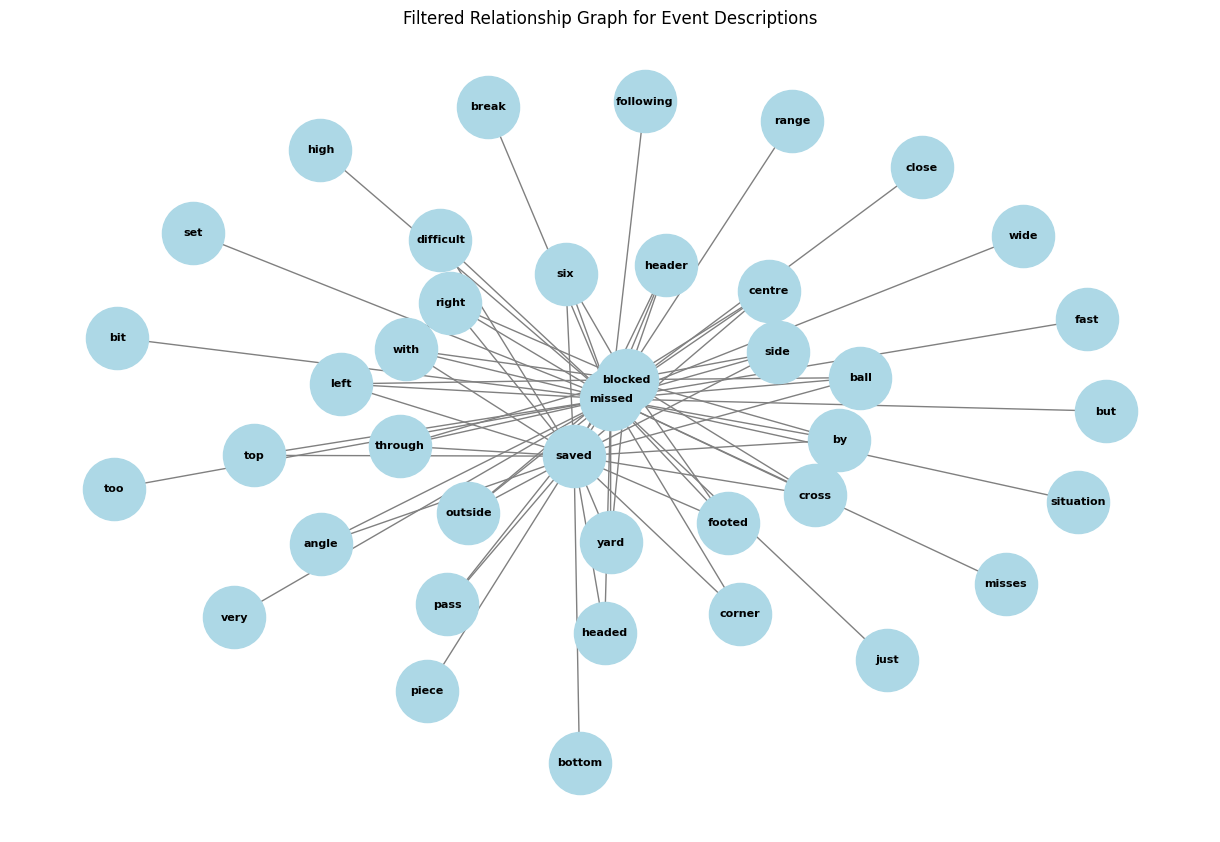

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

df = train_df_balanced

# Count the frequency of each node to filter out less frequent ones
relationship_counts = Counter()
for relationship_string in df['relationships_str']:
    for relationship in relationship_string.split():
        nodes = relationship.split('-')
        relationship_counts.update(nodes)

# Filter out nodes with frequency less than a threshold
threshold = 2
filtered_nodes = {node for node, count in relationship_counts.items() if count >= threshold}

# Create the graph
G = nx.Graph()

for relationship_string in df['relationships_str']:
    for relationship in relationship_string.split():
        nodes = relationship.split('-')
        if len(nodes) == 2 and nodes[0] in filtered_nodes and nodes[1] in filtered_nodes:
            G.add_edge(nodes[0], nodes[1])
        elif len(nodes) == 3 and nodes[0] in filtered_nodes and f"{nodes[1]}-{nodes[2]}" in filtered_nodes:
            G.add_edge(nodes[0], f"{nodes[1]}-{nodes[2]}")

# Use the spring layout for better separation
pos = nx.spring_layout(G, k=0.5)

# Plot the graph with adjusted settings
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=8, font_weight="bold", edge_color="gray", width=1)
plt.title('Filtered Relationship Graph for Event Descriptions')
plt.show()

In [4]:
# Perform TF-IDF on the processed events
tfidf_vectorizer_terms = TfidfVectorizer(max_features=100, stop_words='english')  # Adjust max_features as needed
tfidf_matrix_terms = tfidf_vectorizer_terms.fit_transform(train_df_balanced['processed_event'])

# Combine both TF-IDF matrices
from scipy.sparse import hstack
tfidf_matrix_combined = hstack([tfidf_matrix_terms, relationship_tfidf_matrix])

# Display the shape of the combined matrix
print(tfidf_matrix_combined.shape)


(292, 60)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assume 'match' column is the label indicating if the sentence is important (1) or not (0)
train_df_balanced['match_label'] = train_df_balanced['match'].apply(lambda x: 1 if x else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_combined, train_df_balanced['match_label'], test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.82      0.93      0.87        29

    accuracy                           0.86        59
   macro avg       0.87      0.87      0.86        59
weighted avg       0.87      0.86      0.86        59



In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Prepare the data
train_df_balanced['match_label'] = train_df_balanced['match'].apply(lambda x: 1 if x else 0)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_combined, train_df_balanced['match_label'], test_size=0.2, random_state=42)

# Standardize the features for logistic regression and SVM
scaler = StandardScaler(with_mean=False)  # with_mean=False to support sparse matrices
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression classifier
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_scaled, y_train)
y_pred_lr = lr_clf.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Train a Support Vector Machine classifier
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Train a simple Neural Network using TensorFlow/Keras
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the Neural Network
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype('int32')
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.77      0.93      0.84        29

    accuracy                           0.83        59
   macro avg       0.84      0.83      0.83        59
weighted avg       0.85      0.83      0.83        59

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.77      0.93      0.84        29

    accuracy                           0.83        59
   macro avg       0.84      0.83      0.83        59
weighted avg       0.85      0.83      0.83        59



c:\Users\jeang\OneDrive\Documentos\Thesis\SoccerReport\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6191 - loss: 0.6487 - val_accuracy: 0.6383 - val_loss: 0.6410
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7794 - loss: 0.5287 - val_accuracy: 0.7872 - val_loss: 0.5263
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7628 - loss: 0.4922 - val_accuracy: 0.8511 - val_loss: 0.4490
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8234 - loss: 0.4395 - val_accuracy: 0.8936 - val_loss: 0.3960
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8636 - loss: 0.3874 - val_accuracy: 0.8936 - val_loss: 0.3661
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8368 - loss: 0.3893 - val_accuracy: 0.9149 - val_loss: 0.3398
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8493 - loss: 0.3653 - val_accuracy: 0.9149 - val_loss: 0.3140
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8366 - loss: 0.3519 - val_accuracy: 0.8936 - val_loss: 0.3009


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MaxAbsScaler  # Naive Bayes requires non-negative features

# Prepare the data
train_df_balanced['match_label'] = train_df_balanced['match'].apply(lambda x: 1 if x else 0)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_combined, train_df_balanced['match_label'], test_size=0.2, random_state=42)

# Since Naive Bayes requires non-negative features, use MaxAbsScaler if needed
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Multinomial Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_scaled, y_train)
y_pred_nb = nb_clf.predict(X_test_scaled)

# Evaluate the classifier
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        30
           1       0.70      0.66      0.68        29

    accuracy                           0.69        59
   macro avg       0.70      0.69      0.69        59
weighted avg       0.70      0.69      0.69        59



EVENT EXTRACTOR FINAL

In [13]:
import pandas as pd
import json
import re

# Define the function to parse match time
def parse_match_time(time_str):
    if '+' in time_str:
        base_time, added_time = time_str.split('+')
        return int(base_time.strip("'")) + int(added_time.strip("'"))
    return int(time_str.strip("'")) if time_str != '' else 0

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)
    return text

# Load JSON files
with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/game_to_team.json', 'r', encoding='utf-8') as f:
    game_to_team = json.load(f)

with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json', 'r', encoding='utf-8') as f:
    teamstats = json.load(f)

# List of game IDs to process
#game_ids = [687585]
game_ids = [687630, 687582, 687579, 687617, 687551, 687586, 687590, 
             687623, 687625, 687605, 687618, 687580, 687578, 687568, 687591, 687609, 687541, 687544, 687563, 687607, 687627, 687555]

# Initialize an empty DataFrame to store the results
all_results_df = pd.DataFrame()

csv_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/refined_processed_sentences_withtrueevent.csv'

true_events = pd.read_csv(csv_file_path)

# Function to remove double quotation marks from a string, with handling for non-string inputs
def remove_quotes(text):
    if isinstance(text, str):
        return text.replace('"', '')
    return text  # Return the text unchanged if it is not a string

# Apply the function to the 'event' column, handling potential non-string entries
true_events['event'] = true_events['event'].apply(remove_quotes)

# List of popular team IDs
popular_team_ids = [86, 81, 110, 360, 27, 132, 5, 8, 6, 524, 4, 13, 31, 1068, 124]

# Iterate over each game ID
for gameid in game_ids:
    if str(gameid) not in game_to_team:
        print(f"Game ID {gameid} not found in game_to_team.json")
        continue

    # Get team IDs for the current game
    team1_id = game_to_team[str(gameid)]['team1']
    team2_id = game_to_team[str(gameid)]['team2']

    # Get player names for both teams, ensuring the team ID exists in the teamstats
    team1_players = [player['name'] for player in teamstats.get(team1_id, {}).get('TopScorers', [])]
    team2_players = [player['name'] for player in teamstats.get(team2_id, {}).get('TopScorers', [])]
    
    all_players = set(team1_players + team2_players)

    # Step 1: Filter true_events DataFrame for a specific gameid
    filtered_events = true_events[(true_events['match'] == 'TRUE') & (true_events['gameid'] == int(gameid))]
    
    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    #unique_events = filtered_events['event'].unique()

    # Step 3: Create a new DataFrame from the unique events
    #unique_events_df = pd.DataFrame(unique_events, columns=['Unique Events'])
    

    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    unique_events = filtered_events.drop_duplicates(subset=['event'])

    # Step 3: Create a new DataFrame from the unique events
    # Only selecting 'event' and 'event_tag' for the new DataFrame
    unique_events_df = unique_events[['event', 'event_tag']].reset_index(drop=True)
    unique_events_df.columns = ['Unique Events', 'Event Tag']  # Renaming columns for clarity

    

    # Load JSON data for each game
    file_path = f'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/allCommentary/{gameid}.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({
        'time': list(data['time'].values()),
        'event_type': list(data['type'].values()),
        'details': list(data['dtls'].values())
    })
    
    # Apply the time parsing function
    df['minute'] = df['time'].apply(parse_match_time)
    
    # Filter events based on importance
    important_events = ['goal', 'goal---header', 'goal---volley', 'penalty---saved', 'goal---free-kick', 'red-card', 'shot-hit-woodwork', 
                        'own-goal','penalty---scored']
    test_df = df[df['event_type'].isin(important_events)]
    
    # Look for VAR events using keywords in details
    var_keywords = ['VAR ', 'video assistant referee', 'review', 'Match ends']
    var_events = df[df['details'].str.contains('|'.join(var_keywords), case=False, na=False)]
    
    # Create a boolean mask for details containing 'VAR' or 'video assistant referee'
    mask_details = df['details'].str.contains('VAR|video assistant referee', case=False, na=False)

    # Filter for events with 'event_type' == 'default' and matching details
    preceding_VAR_card = df[(df['event_type'] == 'default') & mask_details]
    preceding_var_indices = preceding_VAR_card.index - 1
    
    # Ensure indices are within the valid range
    valid_indices = preceding_var_indices[preceding_var_indices < len(df)]
    preceding_cards = df.iloc[valid_indices]

    # Create a boolean mask for details containing 'foul'
    mask_details = df['details'].str.contains('foul', case=False, na=False)

    # Create a boolean mask for event_type containing 'penalty'
    mask_event_type = df['event_type'].str.contains('penalty', case=False, na=False)

    # Identify indices of rows where event_type is 'penalty'
    penalty_indices = df[mask_event_type].index

    important_df = pd.concat([test_df, var_events, preceding_cards]).drop_duplicates()

    # Identify matches with combined result <= 2
    match_ends_criteria = df['details'].str.contains('Match ends', case=False, na=False)
    match_ends_df = df[match_ends_criteria]

    combined_result = match_ends_df['details'].apply(lambda x: sum(map(int, re.findall(r'\b\d+\b', x))))


    if combined_result.max() <= 5 and (int(team1_id) in popular_team_ids or int(team2_id) in popular_team_ids):

    
        # Filter for events that immediately precede a goal
        preceding_goal_events = df[df['event_type'] == 'goal']
        preceding_indices = preceding_goal_events.index + 1
        preceding_events = df.loc[preceding_indices]

        # Apply criteria for shot events
        preceding_shots = preceding_events[preceding_events['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]

        # Combine criteria for shot events after the 85th minute or preceding a goal
        important_df = pd.concat([
            important_df,
            preceding_shots
        ]).drop_duplicates().sort_values(by='time')


        # Extract player names mentioned immediately after key events

        def extract_first_player(detail, all_players):
            match = re.search(r'([\w\s]+) \(', detail)
            if match:
                player_name = match.group(1).strip()
                if player_name in all_players:
                    return player_name
            return None

        # Assuming `df` is your dataframe and `all_players` is your list of all player names
        #agregar los goal--volley, goal--header, etc
        goal_players = df[df['event_type'] == 'goal']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
        red_card_players = df[df['event_type'] == 'red-card']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
        penalty_players = df[df['event_type'].str.contains('penalty', case=False)]['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()

        # Extract main players for SBMs and shot-hit-woodwork
        sbm_players = important_df[important_df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()
        shot_hit_woodwork_players = important_df[important_df['event_type'] == 'shot-hit-woodwork']['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()

        # Combine all unique players involved in important events
        important_players = set(goal_players) | set(red_card_players) | set(penalty_players) | set(sbm_players) | set(shot_hit_woodwork_players)

        # Filter to ensure all players are valid
        key_players = [player for player in important_players if player in all_players]

        print(key_players)

        # Handle substitutions
        subs_df = df[df['event_type'] == 'substitution'].copy()
        subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
        
        # Filter for relevant substitutions
        relevant_subs = subs_df[subs_df['subbed_in_player'].isin(key_players)]
        
        # Combine important events and relevant substitutions
        important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

        
        # Check if combined result is <= 2 and at least one team is a popular team
        if combined_result.max() <= 2:

            # Create a copy of the filtered DataFrame
            new_df = df[df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])].copy()

            # Apply the same preprocessing function to the 'event' column of the new data
            new_df.loc[:, 'processed_event'] = new_df['details'].apply(preprocess_text)

            # Create relationships for the new data
            new_df.loc[:, 'relationships'] = new_df['processed_event'].apply(create_relationships)
            new_df.loc[:, 'relationships_str'] = new_df['relationships'].apply(lambda x: ' '.join(x))

            # Transform the new data using the previously fitted TF-IDF vectorizers
            new_tfidf_matrix_terms = tfidf_vectorizer_terms.transform(new_df['processed_event'])
            new_relationship_tfidf_matrix = relationship_vectorizer.transform(new_df['relationships_str'])

            # Combine both TF-IDF matrices
            new_tfidf_matrix_combined = hstack([new_tfidf_matrix_terms, new_relationship_tfidf_matrix])

            # Predict on the new data
            new_predictions = clf.predict(new_tfidf_matrix_combined)

            # Add the predictions to the new DataFrame
            new_df.loc[:, 'predicted_importance'] = new_predictions

            # Filter the dataframe to keep only rows where 'predicted_importance' is 1
            filtered_df = new_df[new_df['predicted_importance'] == 1]

            # Drop the specified columns
            columns_to_drop = ['processed_event', 'relationships', 'relationships_str', 'predicted_importance']
            sbm_events = filtered_df.drop(columns=columns_to_drop)

            # Filter SBM events to include only those with player names in all_players
            sbm_events = sbm_events[sbm_events['details'].apply(lambda x: any(player in x for player in all_players))]

            # Extract player names mentioned immediately after key phrases
            def extract_player(detail):
                match = re.search(r'(Attempt saved|Attempt missed|Attempt blocked)\. ([\w\s]+) \(', detail)
                return match.group(2) if match else None

            sbm_events['main_player'] = sbm_events['details'].apply(extract_player)
            
            # Count occurrences of main player names within SBM events
            sbm_player_counts = sbm_events['main_player'].value_counts()

            # Extract player names mentioned more than once in SBM events
            frequent_sbm_players = sbm_player_counts[sbm_player_counts > 1].index
            sbm_events = sbm_events[sbm_events['main_player'].isin(frequent_sbm_players)]

            # Handle substitutions
            subs_df = df[df['event_type'] == 'substitution'].copy()
            subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
            
            # Filter for relevant substitutions
            relevant_subs = subs_df[subs_df['subbed_in_player'].isin(frequent_sbm_players)]
            
            # Combine important events and relevant substitutions
            important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

            # Create an independent DataFrame for visualization
            sbm_events_df = pd.DataFrame(sbm_events)

            # # Output SBM events for debugging
            # print("SBM Events:")
            # print(sbm_events_df)

            # Step 1: Filter for events with 'event_type' == 'freekick'
            freekick_events = df[df['event_type'] == 'free-kick']

            # Step 2: Calculate the indices of the events immediately after the freekick events
            next_event_indices = freekick_events.index - 1

            # Step 3: Ensure indices are within the valid range
            valid_next_event_indices = next_event_indices[next_event_indices < len(df)]

            # Step 4: Check if the next event contains the word 'corner' in its details
            next_events = df.loc[valid_next_event_indices]
            mask_corner = next_events['details'].str.contains('Corner', case=False, na=False)

            # Step 5: Filter and keep only the valid next events that meet the condition
            next_events_with_corner = next_events[mask_corner]

            # Step 6: Get the corresponding freekick events for the valid next events
            freekick_with_corner_next = freekick_events.loc[next_events_with_corner.index + 1]

            # Step 7: Combine the freekick events and the valid next events
            combined_events = pd.concat([freekick_with_corner_next, next_events_with_corner])

            # Combine all important events
            important_df = pd.concat([important_df, sbm_events,combined_events]).drop_duplicates().sort_values(by='time')
        
    # Normalize the details text
    important_df['details'] = important_df['details'].apply(normalize_text)
    
    # Normalize text for comparison
    unique_events_df['Normalized Events'] = unique_events_df['Unique Events'].apply(lambda x: x.strip().lower())
    important_df['Normalized Details'] = important_df['details'].apply(lambda x: x.strip().lower())
    
    # Find TP, FP, FN
    tp_mask = important_df['Normalized Details'].isin(unique_events_df['Normalized Events'])
    tp_count = tp_mask.sum()
    fp_count = (~tp_mask).sum()
    fn_mask = unique_events_df['Normalized Events'].isin(important_df['Normalized Details'])
    fn_count = (~fn_mask).sum()
    
    # Calculate Precision and Recall
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_score = 2* (precision*recall) / (precision+recall)
    
    # Append results
    results_df = pd.DataFrame({
        'gameid': [gameid],
        'True Positives (TP)': [tp_count],
        'False Positives (FP)': [fp_count],
        'False Negatives (FN)': [fn_count],
        'F1 Score': [f1_score],
        'Precision': [precision],
        'Recall': [recall]
    })

    # Calculate the Total Possible Events. This could be the total number of events in your data or a specific estimated value.
    total_possible_events = len(df)  # You might need to adjust this based on what constitutes a possible event in your context

    # Add a column for True Negatives in your results DataFrame
    results_df['True Negatives (TN)'] = total_possible_events - results_df['True Positives (TP)'] - results_df['False Positives (FP)'] - results_df['False Negatives (FN)']

    # This is an example. You should calculate total_possible_events based on what accurately reflects a possible event in your specific context.

    
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
    
    
    # If precision or recall is below 0.8, display the important_df with FPs and FNs
    # if precision < 0.8 or recall < 0.8:
    #     print(f"\nGame ID: {gameid}")
    #     print(f"Precision: {precision}, Recall: {recall}")
    #     print("False Positives:")
    #     print(important_df[~tp_mask])
    #     print("False Negatives:")
    #     print(unique_events_df[~fn_mask])

# Calculate average precision and recall
average_FP = all_results_df['False Positives (FP)'].mean()
average_FN = all_results_df['False Negatives (FN)'].mean()
average_precision = all_results_df['Precision'].mean()
average_recall = all_results_df['Recall'].mean()

# Calculate overall TP, FP, FN
total_tp = all_results_df['True Positives (TP)'].sum()
total_fp = all_results_df['False Positives (FP)'].sum()
total_fn = all_results_df['False Negatives (FN)'].sum()
total_tn = all_results_df['True Negatives (TN)'].sum()

# Calculate overall precision, recall, and F1 score
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0


# Append average precision, recall, and F1 score to the results
average_results_df = pd.DataFrame({
    'gameid': ['Overall'],
    'True Positives (TP)': [total_tp],
    'False Positives (FP)': [total_fp],
    'False Negatives (FN)': [total_fn],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'F1 Score': [overall_f1_score],
    'True Negatives (TN)': [total_tn]
})

all_results_df = pd.concat([all_results_df, average_results_df], ignore_index=True)

print("min FP=",min(all_results_df['False Positives (FP)']))
print("max FP=",max(all_results_df['False Positives (FP)']))
print("min FN=",min(all_results_df['False Negatives (FN)']))
print("max FN=",max(all_results_df['False Negatives (FN)']))

print("min Recall=",min(all_results_df['Recall']))
print("max Recall=",max(all_results_df['Recall']))
print("min Precision=",min(all_results_df['Precision']))
print("max Precision=",max(all_results_df['Precision']))

# Display the final results
#print(all_results_df)



['Felix Nmecha', 'Callum Wilson', 'Nico Schlotterbeck']
[]
['Kyogo Furuhashi', 'Luis Palma', 'Rodrigo De Paul', "Matt O'Riley", 'Nahuel Molina', 'Daizen Maeda', 'Antoine Griezmann']
['Davide Frattesi', 'Alexis Sánchez', 'Oscar Gloukh', 'Luka Sucic']
['Pablo Barrios', 'Nahuel Molina', 'Luis Alberto']
['Jude Bellingham', 'Rodrygo', 'Federico Valverde']
['Noussair Mazraoui', 'Jamal Musiala', 'Thomas Müller', 'Leon Goretzka', 'Mathys Tel']
min FP= 0
max FP= 28
min FN= 0
max FN= 31
min Recall= 0.6
max Recall= 1.0
min Precision= 0.625
max Precision= 1.0


In [14]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall,True Negatives (TN)
0,687630,9,2,0,0.900000,0.818182,1.000000,111
1,687582,8,1,1,0.888889,0.888889,0.888889,107
2,687579,6,1,0,0.923077,0.857143,1.000000,94
3,687617,4,2,0,0.800000,0.666667,1.000000,91
4,687551,10,1,1,0.909091,0.909091,0.909091,75
5,687586,6,0,1,0.923077,1.000000,0.857143,101
6,687590,4,1,2,0.727273,0.800000,0.666667,125
7,687623,3,0,2,0.750000,1.000000,0.600000,91
8,687625,6,1,2,0.800000,0.857143,0.750000,109
9,687605,6,0,1,0.923077,1.000000,0.857143,93


In [9]:
# Save the updated DataFrame to a new CSV file with UTF-8 encoding
output_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/EventsExtracted_JC.csv'
all_results_df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Updated file saved at: {output_file_path}")

Updated file saved at: C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/EventsExtracted_JC.csv


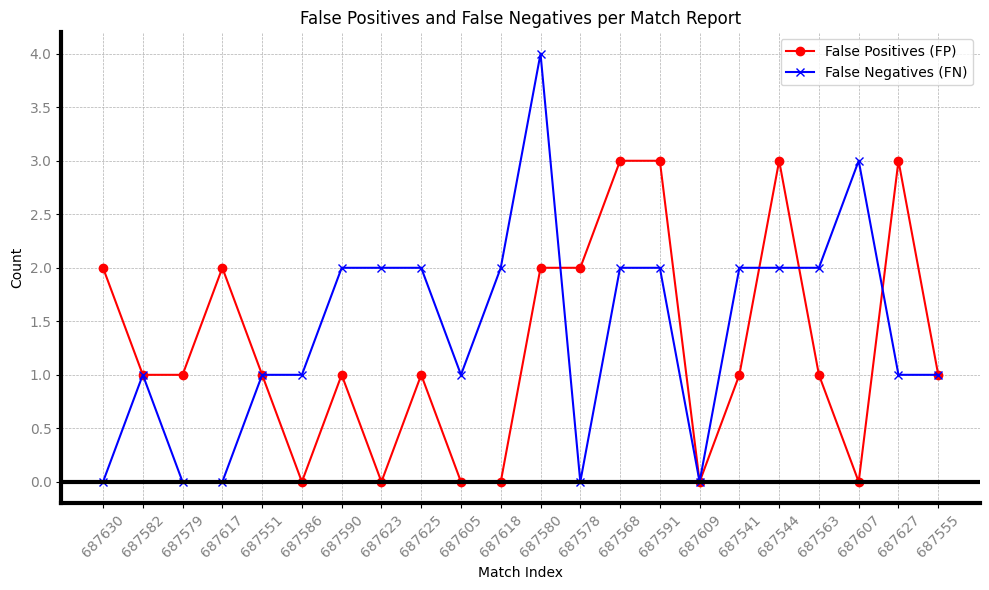

In [17]:
import matplotlib.pyplot as plt

# Select the relevant columns
df = all_results_df[['gameid', 'False Positives (FP)', 'False Negatives (FN)']]

# Drop the 'Average' row if present
df = df[df['gameid'] != 'Average']

# Convert gameid to numeric for plotting
df['gameid'] = pd.to_numeric(df['gameid'])

# Plot the graph
plt.figure(figsize=(10, 6))

# Plotting with the desired style
plt.plot(df.index, df['False Positives (FP)'], label='False Positives (FP)', marker='o', linestyle='-', color='red')
plt.plot(df.index, df['False Negatives (FN)'], label='False Negatives (FN)', marker='x', linestyle='-', color='blue')

# Add a thick line at y = 0
plt.axhline(0, color='black', linewidth=3)

# Add labels and title
plt.xlabel('Match Index')
plt.ylabel('Count')
plt.title('False Positives and False Negatives per Match Report')
plt.legend()

# Customize ticks and grid
plt.xticks(ticks=df.index, labels=df['gameid'], rotation=45, fontsize=10, color='gray')
plt.yticks(fontsize=10, color='gray')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)

plt.tight_layout()
plt.show()

In [43]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,2.000000,0.000000,0.900000,0.818182,1.000000
1,687582,8,1.000000,1.000000,0.888889,0.888889,0.888889
2,687579,6,1.000000,0.000000,0.923077,0.857143,1.000000
3,687617,4,2.000000,0.000000,0.800000,0.666667,1.000000
4,687551,10,1.000000,1.000000,0.909091,0.909091,0.909091
5,687586,6,0.000000,1.000000,0.923077,1.000000,0.857143
6,687590,4,1.000000,2.000000,0.727273,0.800000,0.666667
7,687623,3,0.000000,2.000000,0.750000,1.000000,0.600000
8,687625,6,1.000000,2.000000,0.800000,0.857143,0.750000
9,687605,6,0.000000,1.000000,0.923077,1.000000,0.857143


PHASE 1

In [7]:
import pandas as pd
import json
import re

# Define the function to parse match time
def parse_match_time(time_str):
    if '+' in time_str:
        base_time, added_time = time_str.split('+')
        return int(base_time.strip("'")) + int(added_time.strip("'"))
    return int(time_str.strip("'")) if time_str != '' else 0

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)
    return text

# Load JSON files
with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/game_to_team.json', 'r', encoding='utf-8') as f:
    game_to_team = json.load(f)

with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json', 'r', encoding='utf-8') as f:
    teamstats = json.load(f)

# List of game IDs to process
#game_ids = [687582]
game_ids = [687630, 687582, 687579, 687617, 687551, 687586, 687590, 
             687623, 687625, 687605, 687618, 687580, 687578, 687568, 687591, 687609, 687541, 687544, 687563, 687607, 687627, 687555]

# Initialize an empty DataFrame to store the results
all_results_df = pd.DataFrame()

csv_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/refined_processed_sentences_withtrueevent.csv'

true_events = pd.read_csv(csv_file_path)

# Function to remove double quotation marks from a string, with handling for non-string inputs
def remove_quotes(text):
    if isinstance(text, str):
        return text.replace('"', '')
    return text  # Return the text unchanged if it is not a string

# Apply the function to the 'event' column, handling potential non-string entries
true_events['event'] = true_events['event'].apply(remove_quotes)

# List of popular team IDs
#popular_team_ids = [86, 81, 110, 360, 27, 1, 5, 8, 6, 524, 4, 13, 31, 1068, 124]

# Iterate over each game ID
for gameid in game_ids:
    if str(gameid) not in game_to_team:
        print(f"Game ID {gameid} not found in game_to_team.json")
        continue

    # Get team IDs for the current game
    team1_id = game_to_team[str(gameid)]['team1']
    team2_id = game_to_team[str(gameid)]['team2']

    # Get player names for both teams, ensuring the team ID exists in the teamstats
    team1_players = [player['name'] for player in teamstats.get(team1_id, {}).get('TopScorers', [])]
    team2_players = [player['name'] for player in teamstats.get(team2_id, {}).get('TopScorers', [])]
    
    all_players = set(team1_players + team2_players)

    # Step 1: Filter true_events DataFrame for a specific gameid
    filtered_events = true_events[(true_events['match'] == 'TRUE') & (true_events['gameid'] == int(gameid))]
    
    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    unique_events = filtered_events.drop_duplicates(subset=['event'])

    # Step 3: Create a new DataFrame from the unique events
    # Only selecting 'event' and 'event_tag' for the new DataFrame
    unique_events_df = unique_events[['event', 'event_tag']].reset_index(drop=True)
    unique_events_df.columns = ['Unique Events', 'Event Tag']  # Renaming columns for clarity

    

    # Load JSON data for each game
    file_path = f'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/allCommentary/{gameid}.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({
        'time': list(data['time'].values()),
        'event_type': list(data['type'].values()),
        'details': list(data['dtls'].values())
    })
    
    # Apply the time parsing function
    df['minute'] = df['time'].apply(parse_match_time)
    
    # Filter events based on importance
    important_events = ['goal', 'goal---header', 'goal---volley', 'penalty---saved', 'goal---free-kick', 'red-card', 'shot-hit-woodwork', 
                        'own-goal','penalty---scored']
    test_df = df[df['event_type'].isin(important_events)]
    
    # Look for VAR events using keywords in details
    var_keywords = ['VAR ', 'video assistant referee', 'review', 'Match ends']
    var_events = df[df['details'].str.contains('|'.join(var_keywords), case=False, na=False)]
    
    # Create a boolean mask for details containing 'VAR' or 'video assistant referee'
    mask_details = df['details'].str.contains('VAR|video assistant referee', case=False, na=False)

    # Filter for events with 'event_type' == 'default' and matching details
    preceding_VAR_card = df[(df['event_type'] == 'default') & mask_details]
    preceding_var_indices = preceding_VAR_card.index - 1
    
    important_df = pd.concat([test_df, var_events]).drop_duplicates()

    
    # Normalize the details text
    important_df['details'] = important_df['details'].apply(normalize_text)
    
    # Normalize text for comparison
    unique_events_df['Normalized Events'] = unique_events_df['Unique Events'].apply(lambda x: x.strip().lower())
    important_df['Normalized Details'] = important_df['details'].apply(lambda x: x.strip().lower())
    
    # Find TP, FP, FN
    tp_mask = important_df['Normalized Details'].isin(unique_events_df['Normalized Events'])
    tp_count = tp_mask.sum()
    fp_count = (~tp_mask).sum()
    fn_mask = unique_events_df['Normalized Events'].isin(important_df['Normalized Details'])
    fn_count = (~fn_mask).sum()
    
    # Calculate Precision and Recall
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_score = 2* (precision*recall) / (precision+recall)
    
    # Append results
    results_df = pd.DataFrame({
        'gameid': [gameid],
        'True Positives (TP)': [tp_count],
        'False Positives (FP)': [fp_count],
        'False Negatives (FN)': [fn_count],
        'F1 Score': [f1_score],
        'Precision': [precision],
        'Recall': [recall]
    })
    
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
    

# Calculate overall TP, FP, FN
total_tp = all_results_df['True Positives (TP)'].sum()
total_fp = all_results_df['False Positives (FP)'].sum()
total_fn = all_results_df['False Negatives (FN)'].sum()

# Calculate overall precision, recall, and F1 score
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0


# Append average precision, recall, and F1 score to the results
average_results_df = pd.DataFrame({
    'gameid': ['Overall'],
    'True Positives (TP)': [total_tp],
    'False Positives (FP)': [total_fp],
    'False Negatives (FN)': [total_fn],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'F1 Score': [overall_f1_score]
})

all_results_df = pd.concat([all_results_df, average_results_df], ignore_index=True)
print("min FP=",min(all_results_df['False Positives (FP)']))
print("max FP=",max(all_results_df['False Positives (FP)']))
print("min FN=",min(all_results_df['False Negatives (FN)']))
print("max FN=",max(all_results_df['False Negatives (FN)']))

print("min Recall=",min(all_results_df['Recall']))
print("max Recall=",max(all_results_df['Recall']))
print("min Precision=",min(all_results_df['Precision']))
print("max Precision=",max(all_results_df['Precision']))

# Display the final results
#print(all_results_df)



min FP= 0
max FP= 15
min FN= 0
max FN= 50
min Recall= 0.23076923076923078
max Recall= 1.0
min Precision= 0.6666666666666666
max Precision= 1.0


In [8]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,1,0,0.947368,0.900000,1.000000
1,687582,3,0,6,0.500000,1.000000,0.333333
2,687579,6,1,0,0.923077,0.857143,1.000000
3,687617,4,2,0,0.800000,0.666667,1.000000
4,687551,10,1,1,0.909091,0.909091,0.909091
5,687586,6,0,1,0.923077,1.000000,0.857143
6,687590,4,1,2,0.727273,0.800000,0.666667
7,687623,3,0,2,0.750000,1.000000,0.600000
8,687625,6,1,2,0.800000,0.857143,0.750000
9,687605,6,0,1,0.923077,1.000000,0.857143


PHASE 1, 2

In [9]:
import pandas as pd
import json
import re

# Define the function to parse match time
def parse_match_time(time_str):
    if '+' in time_str:
        base_time, added_time = time_str.split('+')
        return int(base_time.strip("'")) + int(added_time.strip("'"))
    return int(time_str.strip("'")) if time_str != '' else 0

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)
    return text

# Load JSON files
with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/game_to_team.json', 'r', encoding='utf-8') as f:
    game_to_team = json.load(f)

with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json', 'r', encoding='utf-8') as f:
    teamstats = json.load(f)

# List of game IDs to process
#game_ids = [687585]
game_ids = [687630, 687582, 687579, 687617, 687551, 687586, 687590, 
             687623, 687625, 687605, 687618, 687580, 687578, 687568, 687591, 687609, 687541, 687544, 687563, 687607, 687627, 687555]

# Initialize an empty DataFrame to store the results
all_results_df = pd.DataFrame()

csv_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/refined_processed_sentences_withtrueevent.csv'

true_events = pd.read_csv(csv_file_path)

# Function to remove double quotation marks from a string, with handling for non-string inputs
def remove_quotes(text):
    if isinstance(text, str):
        return text.replace('"', '')
    return text  # Return the text unchanged if it is not a string

# Apply the function to the 'event' column, handling potential non-string entries
true_events['event'] = true_events['event'].apply(remove_quotes)

# Iterate over each game ID
for gameid in game_ids:
    if str(gameid) not in game_to_team:
        print(f"Game ID {gameid} not found in game_to_team.json")
        continue

    # Get team IDs for the current game
    team1_id = game_to_team[str(gameid)]['team1']
    team2_id = game_to_team[str(gameid)]['team2']

    # Get player names for both teams, ensuring the team ID exists in the teamstats
    team1_players = [player['name'] for player in teamstats.get(team1_id, {}).get('TopScorers', [])]
    team2_players = [player['name'] for player in teamstats.get(team2_id, {}).get('TopScorers', [])]
    
    all_players = set(team1_players + team2_players)

    # Step 1: Filter true_events DataFrame for a specific gameid
    filtered_events = true_events[(true_events['match'] == 'TRUE') & (true_events['gameid'] == int(gameid))]
        
    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    unique_events = filtered_events.drop_duplicates(subset=['event'])

    # Step 3: Create a new DataFrame from the unique events
    # Only selecting 'event' and 'event_tag' for the new DataFrame
    unique_events_df = unique_events[['event', 'event_tag']].reset_index(drop=True)
    unique_events_df.columns = ['Unique Events', 'Event Tag']  # Renaming columns for clarity

    

    # Load JSON data for each game
    file_path = f'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/allCommentary/{gameid}.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({
        'time': list(data['time'].values()),
        'event_type': list(data['type'].values()),
        'details': list(data['dtls'].values())
    })
    
    # Apply the time parsing function
    df['minute'] = df['time'].apply(parse_match_time)
    
    # Filter events based on importance
    important_events = ['goal', 'goal---header', 'goal---volley', 'penalty---saved', 'goal---free-kick', 'red-card', 'shot-hit-woodwork', 
                        'own-goal','penalty---scored']
    test_df = df[df['event_type'].isin(important_events)]
    
    # Look for VAR events using keywords in details
    var_keywords = ['VAR ', 'video assistant referee', 'review', 'Match ends']
    var_events = df[df['details'].str.contains('|'.join(var_keywords), case=False, na=False)]
    
    # Create a boolean mask for details containing 'VAR' or 'video assistant referee'
    mask_details = df['details'].str.contains('VAR|video assistant referee', case=False, na=False)

    # Filter for events with 'event_type' == 'default' and matching details
    preceding_VAR_card = df[(df['event_type'] == 'default') & mask_details]
    preceding_var_indices = preceding_VAR_card.index - 1
    
    # Ensure indices are within the valid range
    valid_indices = preceding_var_indices[preceding_var_indices < len(df)]
    preceding_cards = df.iloc[valid_indices]

    # Create a boolean mask for details containing 'foul'
    mask_details = df['details'].str.contains('foul', case=False, na=False)

    # Create a boolean mask for event_type containing 'penalty'
    mask_event_type = df['event_type'].str.contains('penalty', case=False, na=False)

    # Identify indices of rows where event_type is 'penalty'
    penalty_indices = df[mask_event_type].index

    important_df = pd.concat([test_df, var_events, preceding_cards]).drop_duplicates()

    
    # Filter for events that immediately precede a goal
    preceding_goal_events = df[df['event_type'] == 'goal']
    preceding_indices = preceding_goal_events.index + 1
    preceding_events = df.loc[preceding_indices]

    # Apply criteria for shot events
    preceding_shots = preceding_events[preceding_events['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]

    # Combine criteria for shot events after the 85th minute or preceding a goal
    important_df = pd.concat([
        important_df,
        preceding_shots
    ]).drop_duplicates().sort_values(by='time')

    # Normalize the details text
    important_df['details'] = important_df['details'].apply(normalize_text)
    
    # Normalize text for comparison
    unique_events_df['Normalized Events'] = unique_events_df['Unique Events'].apply(lambda x: x.strip().lower())
    important_df['Normalized Details'] = important_df['details'].apply(lambda x: x.strip().lower())
    
    # Find TP, FP, FN
    tp_mask = important_df['Normalized Details'].isin(unique_events_df['Normalized Events'])
    tp_count = tp_mask.sum()
    fp_count = (~tp_mask).sum()
    fn_mask = unique_events_df['Normalized Events'].isin(important_df['Normalized Details'])
    fn_count = (~fn_mask).sum()
    
    # Calculate Precision and Recall
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_score = 2* (precision*recall) / (precision+recall)
    
    # Append results
    results_df = pd.DataFrame({
        'gameid': [gameid],
        'True Positives (TP)': [tp_count],
        'False Positives (FP)': [fp_count],
        'False Negatives (FN)': [fn_count],
        'F1 Score': [f1_score],
        'Precision': [precision],
        'Recall': [recall]
    })
    
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
    
    
    # If precision or recall is below 0.8, display the important_df with FPs and FNs
    if precision < 0.8 or recall < 0.8:
        print(f"\nGame ID: {gameid}")
        print(f"Precision: {precision}, Recall: {recall}")
        print("False Positives:")
        print(important_df[~tp_mask])
        print("False Negatives:")
        print(unique_events_df[~fn_mask])

# Calculate average precision and recall
average_FP = all_results_df['False Positives (FP)'].mean()
average_FN = all_results_df['False Negatives (FN)'].mean()
average_precision = all_results_df['Precision'].mean()
average_recall = all_results_df['Recall'].mean()

# Calculate overall TP, FP, FN
total_tp = all_results_df['True Positives (TP)'].sum()
total_fp = all_results_df['False Positives (FP)'].sum()
total_fn = all_results_df['False Negatives (FN)'].sum()

# Calculate overall precision, recall, and F1 score
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0


# Append average precision, recall, and F1 score to the results
average_results_df = pd.DataFrame({
    'gameid': ['Overall'],
    'True Positives (TP)': [total_tp],
    'False Positives (FP)': [total_fp],
    'False Negatives (FN)': [total_fn],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'F1 Score': [overall_f1_score]
})

all_results_df = pd.concat([all_results_df, average_results_df], ignore_index=True)

print("min FP=",min(all_results_df['False Positives (FP)']))
print("max FP=",max(all_results_df['False Positives (FP)']))
print("min FN=",min(all_results_df['False Negatives (FN)']))
print("max FN=",max(all_results_df['False Negatives (FN)']))

print("min Recall=",min(all_results_df['Recall']))
print("max Recall=",max(all_results_df['Recall']))
print("min Precision=",min(all_results_df['Precision']))
print("max Precision=",max(all_results_df['Precision']))

# Display the final results
#print(all_results_df)




Game ID: 687582
Precision: 1.0, Recall: 0.3333333333333333
False Positives:
Empty DataFrame
Columns: [time, event_type, details, minute, Normalized Details]
Index: []
False Negatives:
                                       Unique Events       Event Tag  \
3  Attempt blocked. Donyell Malen (Borussia Dortm...    shot-blocked   
4  Attempt saved. Anthony Gordon (Newcastle Unite...  shot-on-target   
5  Attempt saved. Anthony Gordon (Newcastle Unite...  shot-on-target   
6  Substitution, Newcastle United. Callum Wilson ...    substitution   
7  Attempt saved. Callum Wilson (Newcastle United...  shot-on-target   
8  Attempt blocked. Anthony Gordon (Newcastle Uni...    shot-blocked   

                                   Normalized Events  
3  attempt blocked. donyell malen (borussia dortm...  
4  attempt saved. anthony gordon (newcastle unite...  
5  attempt saved. anthony gordon (newcastle unite...  
6  substitution, newcastle united. callum wilson ...  
7  attempt saved. callum wilson (ne

In [10]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,2,0,0.900000,0.818182,1.000000
1,687582,3,0,6,0.500000,1.000000,0.333333
2,687579,6,2,0,0.857143,0.750000,1.000000
3,687617,4,3,0,0.727273,0.571429,1.000000
4,687551,10,2,1,0.869565,0.833333,0.909091
5,687586,6,1,1,0.857143,0.857143,0.857143
6,687590,4,2,2,0.666667,0.666667,0.666667
7,687623,3,0,2,0.750000,1.000000,0.600000
8,687625,6,2,2,0.750000,0.750000,0.750000
9,687605,6,1,1,0.857143,0.857143,0.857143


PHASE 1,2,3

In [11]:
import pandas as pd
import json
import re

# Define the function to parse match time
def parse_match_time(time_str):
    if '+' in time_str:
        base_time, added_time = time_str.split('+')
        return int(base_time.strip("'")) + int(added_time.strip("'"))
    return int(time_str.strip("'")) if time_str != '' else 0

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)
    return text

# Load JSON files
with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/game_to_team.json', 'r', encoding='utf-8') as f:
    game_to_team = json.load(f)

with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json', 'r', encoding='utf-8') as f:
    teamstats = json.load(f)

# List of game IDs to process
#game_ids = [687582]
game_ids = [687630, 687582, 687579, 687617, 687551, 687586, 687590, 
             687623, 687625, 687605, 687618, 687580, 687578, 687568, 687591, 687609, 687541, 687544, 687563, 687607, 687627, 687555]

# Initialize an empty DataFrame to store the results
all_results_df = pd.DataFrame()

csv_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/refined_processed_sentences_withtrueevent.csv'

true_events = pd.read_csv(csv_file_path)

# Function to remove double quotation marks from a string, with handling for non-string inputs
def remove_quotes(text):
    if isinstance(text, str):
        return text.replace('"', '')
    return text  # Return the text unchanged if it is not a string

# Apply the function to the 'event' column, handling potential non-string entries
true_events['event'] = true_events['event'].apply(remove_quotes)

# List of popular team IDs
popular_team_ids = [86, 81, 110, 360, 27, 1, 5, 8, 6, 524, 4, 13, 31, 1068, 124]

# Iterate over each game ID
for gameid in game_ids:
    if str(gameid) not in game_to_team:
        print(f"Game ID {gameid} not found in game_to_team.json")
        continue

    # Get team IDs for the current game
    team1_id = game_to_team[str(gameid)]['team1']
    team2_id = game_to_team[str(gameid)]['team2']

    # Get player names for both teams, ensuring the team ID exists in the teamstats
    team1_players = [player['name'] for player in teamstats.get(team1_id, {}).get('TopScorers', [])]
    team2_players = [player['name'] for player in teamstats.get(team2_id, {}).get('TopScorers', [])]
    
    all_players = set(team1_players + team2_players)

    # Step 1: Filter true_events DataFrame for a specific gameid
    filtered_events = true_events[(true_events['match'] == 'TRUE') & (true_events['gameid'] == int(gameid))]
    

    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    unique_events = filtered_events.drop_duplicates(subset=['event'])

    # Step 3: Create a new DataFrame from the unique events
    # Only selecting 'event' and 'event_tag' for the new DataFrame
    unique_events_df = unique_events[['event', 'event_tag']].reset_index(drop=True)
    unique_events_df.columns = ['Unique Events', 'Event Tag']  # Renaming columns for clarity

    

    # Load JSON data for each game
    file_path = f'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/allCommentary/{gameid}.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({
        'time': list(data['time'].values()),
        'event_type': list(data['type'].values()),
        'details': list(data['dtls'].values())
    })
    
    # Apply the time parsing function
    df['minute'] = df['time'].apply(parse_match_time)
    
    # Filter events based on importance
    important_events = ['goal', 'goal---header', 'goal---volley', 'penalty---saved', 'goal---free-kick', 'red-card', 'shot-hit-woodwork', 
                        'own-goal','penalty---scored']
    test_df = df[df['event_type'].isin(important_events)]
    
    # Look for VAR events using keywords in details
    var_keywords = ['VAR ', 'video assistant referee', 'review', 'Match ends']
    var_events = df[df['details'].str.contains('|'.join(var_keywords), case=False, na=False)]
    
    # Create a boolean mask for details containing 'VAR' or 'video assistant referee'
    mask_details = df['details'].str.contains('VAR|video assistant referee', case=False, na=False)

    # Filter for events with 'event_type' == 'default' and matching details
    preceding_VAR_card = df[(df['event_type'] == 'default') & mask_details]
    preceding_var_indices = preceding_VAR_card.index - 1
    
    # Ensure indices are within the valid range
    valid_indices = preceding_var_indices[preceding_var_indices < len(df)]
    preceding_cards = df.iloc[valid_indices]

    # Create a boolean mask for details containing 'foul'
    mask_details = df['details'].str.contains('foul', case=False, na=False)

    # Create a boolean mask for event_type containing 'penalty'
    mask_event_type = df['event_type'].str.contains('penalty', case=False, na=False)

    # Identify indices of rows where event_type is 'penalty'
    penalty_indices = df[mask_event_type].index

    important_df = pd.concat([test_df, var_events]).drop_duplicates()

    # Filter for events that immediately precede a goal
    preceding_goal_events = df[df['event_type'] == 'goal']
    preceding_indices = preceding_goal_events.index + 1
    preceding_events = df.loc[preceding_indices]

    # Apply criteria for shot events
    preceding_shots = preceding_events[preceding_events['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]

    #Combine criteria for shot events after the 85th minute or preceding a goal
    important_df = pd.concat([
        important_df,
        preceding_shots
    ]).drop_duplicates().sort_values(by='time')


    # Extract player names mentioned immediately after key events

    def extract_first_player(detail, all_players):
        match = re.search(r'([\w\s]+) \(', detail)
        if match:
            player_name = match.group(1).strip()
            if player_name in all_players:
                return player_name
        return None

    # Assuming `df` is your dataframe and `all_players` is your list of all player names
    #agregar los goal--volley, goal--header, etc
    goal_players = df[df['event_type'] == 'goal']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
    red_card_players = df[df['event_type'] == 'red-card']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
    penalty_players = df[df['event_type'].str.contains('penalty', case=False)]['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()

    # Extract main players for SBMs and shot-hit-woodwork
    sbm_players = important_df[important_df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()
    shot_hit_woodwork_players = important_df[important_df['event_type'] == 'shot-hit-woodwork']['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()

    # Combine all unique players involved in important events
    important_players = set(goal_players) | set(red_card_players) | set(penalty_players) | set(sbm_players) | set(shot_hit_woodwork_players)

    # Filter to ensure all players are valid
    key_players = [player for player in important_players if player in all_players]

    #print(key_players)

    # Handle substitutions
    subs_df = df[df['event_type'] == 'substitution'].copy()
    subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
    
    # Filter for relevant substitutions
    relevant_subs = subs_df[subs_df['subbed_in_player'].isin(key_players)]
    
    # Combine important events and relevant substitutions
    important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

    # Normalize the details text
    important_df['details'] = important_df['details'].apply(normalize_text)
    
    
    # Normalize text for comparison
    unique_events_df['Normalized Events'] = unique_events_df['Unique Events'].apply(lambda x: x.strip().lower())
    important_df['Normalized Details'] = important_df['details'].apply(lambda x: x.strip().lower())
    
    # Find TP, FP, FN
    tp_mask = important_df['Normalized Details'].isin(unique_events_df['Normalized Events'])
    tp_count = tp_mask.sum()
    fp_count = (~tp_mask).sum()
    fn_mask = unique_events_df['Normalized Events'].isin(important_df['Normalized Details'])
    fn_count = (~fn_mask).sum()
    
    # Calculate Precision and Recall
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_score = 2* (precision*recall) / (precision+recall)
    
    # Append results
    results_df = pd.DataFrame({
        'gameid': [gameid],
        'True Positives (TP)': [tp_count],
        'False Positives (FP)': [fp_count],
        'False Negatives (FN)': [fn_count],
        'F1 Score': [f1_score],
        'Precision': [precision],
        'Recall': [recall]
    })
    
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
    
# Calculate average precision and recall
average_FP = all_results_df['False Positives (FP)'].mean()
average_FN = all_results_df['False Negatives (FN)'].mean()
average_precision = all_results_df['Precision'].mean()
average_recall = all_results_df['Recall'].mean()

# Calculate overall TP, FP, FN
total_tp = all_results_df['True Positives (TP)'].sum()
total_fp = all_results_df['False Positives (FP)'].sum()
total_fn = all_results_df['False Negatives (FN)'].sum()

# Calculate overall precision, recall, and F1 score
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0


# Append average precision, recall, and F1 score to the results
average_results_df = pd.DataFrame({
    'gameid': ['Overall'],
    'True Positives (TP)': [total_tp],
    'False Positives (FP)': [total_fp],
    'False Negatives (FN)': [total_fn],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'F1 Score': [overall_f1_score]
})

all_results_df = pd.concat([all_results_df, average_results_df], ignore_index=True)
print("min FP=",min(all_results_df['False Positives (FP)']))
print("max FP=",max(all_results_df['False Positives (FP)']))
print("min FN=",min(all_results_df['False Negatives (FN)']))
print("max FN=",max(all_results_df['False Negatives (FN)']))

print("min Recall=",min(all_results_df['Recall']))
print("max Recall=",max(all_results_df['Recall']))
print("min Precision=",min(all_results_df['Precision']))
print("max Precision=",max(all_results_df['Precision']))

# Display the final results
#print(all_results_df)



min FP= 0
max FP= 43
min FN= 0
max FN= 41
min Recall= 0.38461538461538464
max Recall= 1.0
min Precision= 0.5
max Precision= 1.0


In [12]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,2,0,0.900000,0.818182,1.000000
1,687582,4,0,5,0.615385,1.000000,0.444444
2,687579,6,2,0,0.857143,0.750000,1.000000
3,687617,4,4,0,0.666667,0.500000,1.000000
4,687551,10,5,1,0.769231,0.666667,0.909091
5,687586,6,1,1,0.857143,0.857143,0.857143
6,687590,4,2,2,0.666667,0.666667,0.666667
7,687623,3,0,2,0.750000,1.000000,0.600000
8,687625,6,2,2,0.750000,0.750000,0.750000
9,687605,6,2,1,0.800000,0.750000,0.857143


PHASE 1,2,3,4

In [19]:
import pandas as pd
import json
import re

# Define the function to parse match time
def parse_match_time(time_str):
    if '+' in time_str:
        base_time, added_time = time_str.split('+')
        return int(base_time.strip("'")) + int(added_time.strip("'"))
    return int(time_str.strip("'")) if time_str != '' else 0

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)
    return text

# Load JSON files
with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/game_to_team.json', 'r', encoding='utf-8') as f:
    game_to_team = json.load(f)

with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json', 'r', encoding='utf-8') as f:
    teamstats = json.load(f)

# List of game IDs to process
#game_ids = [687585]
game_ids = [687630, 687582, 687579, 687617, 687551, 687586, 687590, 
             687623, 687625, 687605, 687618, 687580, 687578, 687568, 687591, 687609, 687541, 687544, 687563, 687607, 687627, 687555]

# Initialize an empty DataFrame to store the results
all_results_df = pd.DataFrame()

csv_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/refined_processed_sentences_withtrueevent.csv'

true_events = pd.read_csv(csv_file_path)

# Function to remove double quotation marks from a string, with handling for non-string inputs
def remove_quotes(text):
    if isinstance(text, str):
        return text.replace('"', '')
    return text  # Return the text unchanged if it is not a string

# Apply the function to the 'event' column, handling potential non-string entries
true_events['event'] = true_events['event'].apply(remove_quotes)

# List of popular team IDs
popular_team_ids = [86, 81, 110, 360, 27, 132, 5, 8, 6, 524, 4, 13, 31, 1068, 124]

# Iterate over each game ID
for gameid in game_ids:
    if str(gameid) not in game_to_team:
        print(f"Game ID {gameid} not found in game_to_team.json")
        continue

    # Get team IDs for the current game
    team1_id = game_to_team[str(gameid)]['team1']
    team2_id = game_to_team[str(gameid)]['team2']

    # Get player names for both teams, ensuring the team ID exists in the teamstats
    team1_players = [player['name'] for player in teamstats.get(team1_id, {}).get('TopScorers', [])]
    team2_players = [player['name'] for player in teamstats.get(team2_id, {}).get('TopScorers', [])]
    
    all_players = set(team1_players + team2_players)

    # Step 1: Filter true_events DataFrame for a specific gameid
    filtered_events = true_events[(true_events['match'] == 'TRUE') & (true_events['gameid'] == int(gameid))]
        

    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    unique_events = filtered_events.drop_duplicates(subset=['event'])

    # Step 3: Create a new DataFrame from the unique events
    # Only selecting 'event' and 'event_tag' for the new DataFrame
    unique_events_df = unique_events[['event', 'event_tag']].reset_index(drop=True)
    unique_events_df.columns = ['Unique Events', 'Event Tag']  # Renaming columns for clarity

    

    # Load JSON data for each game
    file_path = f'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/allCommentary/{gameid}.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({
        'time': list(data['time'].values()),
        'event_type': list(data['type'].values()),
        'details': list(data['dtls'].values())
    })
    
    # Apply the time parsing function
    df['minute'] = df['time'].apply(parse_match_time)
    
    # Filter events based on importance
    important_events = ['goal', 'goal---header', 'goal---volley', 'penalty---saved', 'goal---free-kick', 'red-card', 'shot-hit-woodwork', 
                        'own-goal','penalty---scored']
    test_df = df[df['event_type'].isin(important_events)]
    
    # Look for VAR events using keywords in details
    var_keywords = ['VAR ', 'video assistant referee', 'review', 'Match ends']
    var_events = df[df['details'].str.contains('|'.join(var_keywords), case=False, na=False)]
    
    # Create a boolean mask for details containing 'VAR' or 'video assistant referee'
    mask_details = df['details'].str.contains('VAR|video assistant referee', case=False, na=False)

    # Filter for events with 'event_type' == 'default' and matching details
    preceding_VAR_card = df[(df['event_type'] == 'default') & mask_details]
    preceding_var_indices = preceding_VAR_card.index - 1
    
    # Ensure indices are within the valid range
    valid_indices = preceding_var_indices[preceding_var_indices < len(df)]
    preceding_cards = df.iloc[valid_indices]

    # Create a boolean mask for details containing 'foul'
    mask_details = df['details'].str.contains('foul', case=False, na=False)

    # Create a boolean mask for event_type containing 'penalty'
    mask_event_type = df['event_type'].str.contains('penalty', case=False, na=False)

    # Identify indices of rows where event_type is 'penalty'
    penalty_indices = df[mask_event_type].index

    important_df = pd.concat([test_df, var_events, preceding_cards]).drop_duplicates()

    # Identify matches with combined result <= 2
    match_ends_criteria = df['details'].str.contains('Match ends', case=False, na=False)
    match_ends_df = df[match_ends_criteria]

    combined_result = match_ends_df['details'].apply(lambda x: sum(map(int, re.findall(r'\b\d+\b', x))))
    
    # Filter for events that immediately precede a goal
    preceding_goal_events = df[df['event_type'] == 'goal']
    preceding_indices = preceding_goal_events.index + 1
    preceding_events = df.loc[preceding_indices]

    # Apply criteria for shot events
    preceding_shots = preceding_events[preceding_events['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]

    # Combine criteria for shot events after the 85th minute or preceding a goal
    important_df = pd.concat([
        important_df,
        preceding_shots
    ]).drop_duplicates().sort_values(by='time')


    # Extract player names mentioned immediately after key events

    def extract_first_player(detail, all_players):
        match = re.search(r'([\w\s]+) \(', detail)
        if match:
            player_name = match.group(1).strip()
            if player_name in all_players:
                return player_name
        return None

    # Assuming `df` is your dataframe and `all_players` is your list of all player names
    #agregar los goal--volley, goal--header, etc
    goal_players = df[df['event_type'] == 'goal']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
    red_card_players = df[df['event_type'] == 'red-card']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
    penalty_players = df[df['event_type'].str.contains('penalty', case=False)]['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()

    # Extract main players for SBMs and shot-hit-woodwork
    sbm_players = important_df[important_df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()
    shot_hit_woodwork_players = important_df[important_df['event_type'] == 'shot-hit-woodwork']['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()

    # Combine all unique players involved in important events
    important_players = set(goal_players) | set(red_card_players) | set(penalty_players) | set(sbm_players) | set(shot_hit_woodwork_players)

    # Filter to ensure all players are valid
    key_players = [player for player in important_players if player in all_players]

    print(key_players)

    # Handle substitutions
    subs_df = df[df['event_type'] == 'substitution'].copy()
    subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
    
    # Filter for relevant substitutions
    relevant_subs = subs_df[subs_df['subbed_in_player'].isin(key_players)]
    
    # Combine important events and relevant substitutions
    important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

    
    # Check if combined result is <= 2 and at least one team is a popular team
    if combined_result.max() <= 2:

        # Create a copy of the filtered DataFrame
        new_df = df[df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])].copy()

        # Apply the same preprocessing function to the 'event' column of the new data
        new_df.loc[:, 'processed_event'] = new_df['details'].apply(preprocess_text)

        # Create relationships for the new data
        new_df.loc[:, 'relationships'] = new_df['processed_event'].apply(create_relationships)
        new_df.loc[:, 'relationships_str'] = new_df['relationships'].apply(lambda x: ' '.join(x))

        # Transform the new data using the previously fitted TF-IDF vectorizers
        new_tfidf_matrix_terms = tfidf_vectorizer_terms.transform(new_df['processed_event'])
        new_relationship_tfidf_matrix = relationship_vectorizer.transform(new_df['relationships_str'])

        # Combine both TF-IDF matrices
        new_tfidf_matrix_combined = hstack([new_tfidf_matrix_terms, new_relationship_tfidf_matrix])

        # Predict on the new data
        new_predictions = clf.predict(new_tfidf_matrix_combined)

        # Add the predictions to the new DataFrame
        new_df.loc[:, 'predicted_importance'] = new_predictions

        # Filter the dataframe to keep only rows where 'predicted_importance' is 1
        filtered_df = new_df[new_df['predicted_importance'] == 1]

        # Drop the specified columns
        columns_to_drop = ['processed_event', 'relationships', 'relationships_str', 'predicted_importance']
        sbm_events = filtered_df.drop(columns=columns_to_drop)

        # Filter SBM events to include only those with player names in all_players
        sbm_events = sbm_events[sbm_events['details'].apply(lambda x: any(player in x for player in all_players))]

        # Extract player names mentioned immediately after key phrases
        def extract_player(detail):
            match = re.search(r'(Attempt saved|Attempt missed|Attempt blocked)\. ([\w\s]+) \(', detail)
            return match.group(2) if match else None

        sbm_events['main_player'] = sbm_events['details'].apply(extract_player)
        
        # Count occurrences of main player names within SBM events
        sbm_player_counts = sbm_events['main_player'].value_counts()

        # Extract player names mentioned more than once in SBM events
        frequent_sbm_players = sbm_player_counts[sbm_player_counts > 1].index
        sbm_events = sbm_events[sbm_events['main_player'].isin(frequent_sbm_players)]

        # Handle substitutions
        subs_df = df[df['event_type'] == 'substitution'].copy()
        subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
        
        # Filter for relevant substitutions
        relevant_subs = subs_df[subs_df['subbed_in_player'].isin(frequent_sbm_players)]
        
        # Combine important events and relevant substitutions
        important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

        # Create an independent DataFrame for visualization
        sbm_events_df = pd.DataFrame(sbm_events)

        # Step 1: Filter for events with 'event_type' == 'freekick'
        freekick_events = df[df['event_type'] == 'free-kick']

        # Step 2: Calculate the indices of the events immediately after the freekick events
        next_event_indices = freekick_events.index - 1

        # Step 3: Ensure indices are within the valid range
        valid_next_event_indices = next_event_indices[next_event_indices < len(df)]

        # Step 4: Check if the next event contains the word 'corner' in its details
        next_events = df.loc[valid_next_event_indices]
        mask_corner = next_events['details'].str.contains('Corner', case=False, na=False)

        # Step 5: Filter and keep only the valid next events that meet the condition
        next_events_with_corner = next_events[mask_corner]

        # Step 6: Get the corresponding freekick events for the valid next events
        freekick_with_corner_next = freekick_events.loc[next_events_with_corner.index + 1]

        # Step 7: Combine the freekick events and the valid next events
        combined_events = pd.concat([freekick_with_corner_next, next_events_with_corner])

        # Combine all important events
        important_df = pd.concat([important_df, sbm_events,combined_events]).drop_duplicates().sort_values(by='time')
        
    # Normalize the details text
    important_df['details'] = important_df['details'].apply(normalize_text)
    
    # Normalize text for comparison
    unique_events_df['Normalized Events'] = unique_events_df['Unique Events'].apply(lambda x: x.strip().lower())
    important_df['Normalized Details'] = important_df['details'].apply(lambda x: x.strip().lower())
    
    # Find TP, FP, FN
    tp_mask = important_df['Normalized Details'].isin(unique_events_df['Normalized Events'])
    tp_count = tp_mask.sum()
    fp_count = (~tp_mask).sum()
    fn_mask = unique_events_df['Normalized Events'].isin(important_df['Normalized Details'])
    fn_count = (~fn_mask).sum()
    
    # Calculate Precision and Recall
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_score = 2* (precision*recall) / (precision+recall)
    
    # Append results
    results_df = pd.DataFrame({
        'gameid': [gameid],
        'True Positives (TP)': [tp_count],
        'False Positives (FP)': [fp_count],
        'False Negatives (FN)': [fn_count],
        'F1 Score': [f1_score],
        'Precision': [precision],
        'Recall': [recall]
    })
    
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
    
    
    # If precision or recall is below 0.8, display the important_df with FPs and FNs
    if precision < 0.8 or recall < 0.8:
        print(f"\nGame ID: {gameid}")
        print(f"Precision: {precision}, Recall: {recall}")
        print("False Positives:")
        print(important_df[~tp_mask])
        print("False Negatives:")
        print(unique_events_df[~fn_mask])

# Calculate average precision and recall
average_FP = all_results_df['False Positives (FP)'].mean()
average_FN = all_results_df['False Negatives (FN)'].mean()
average_precision = all_results_df['Precision'].mean()
average_recall = all_results_df['Recall'].mean()

# Calculate overall TP, FP, FN
total_tp = all_results_df['True Positives (TP)'].sum()
total_fp = all_results_df['False Positives (FP)'].sum()
total_fn = all_results_df['False Negatives (FN)'].sum()

# Calculate overall precision, recall, and F1 score
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0


# Append average precision, recall, and F1 score to the results
average_results_df = pd.DataFrame({
    'gameid': ['Overall'],
    'True Positives (TP)': [total_tp],
    'False Positives (FP)': [total_fp],
    'False Negatives (FN)': [total_fn],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'F1 Score': [overall_f1_score]
})

all_results_df = pd.concat([all_results_df, average_results_df], ignore_index=True)

print("min FP=",min(all_results_df['False Positives (FP)']))
print("max FP=",max(all_results_df['False Positives (FP)']))
print("min FN=",min(all_results_df['False Negatives (FN)']))
print("max FN=",max(all_results_df['False Negatives (FN)']))

print("min Recall=",min(all_results_df['Recall']))
print("max Recall=",max(all_results_df['Recall']))
print("min Precision=",min(all_results_df['Precision']))
print("max Precision=",max(all_results_df['Precision']))

# Display the final results
#print(all_results_df)



['Galeno', 'Pepê', 'Mehdi Taremi', 'Francisco Conceição', 'Evanilson', 'Pepe']

Game ID: 687630
Precision: 0.75, Recall: 1.0
False Positives:
   time    event_type                                            details  \
83  30'       default  VAR Decision: Goal FC Porto 1-1 Shakhtar Donet...   
82  32'          foul         Foul by Dmytro Kryskiv (Shakhtar Donetsk).   
28  81'  substitution  Substitution, FC Porto. Francisco Conceição re...   

    minute     subbed_in_player  \
83      30                  NaN   
82      32                  NaN   
28      81  Francisco Conceição   

                                   Normalized Details  
83  var decision: goal fc porto 1-1 shakhtar donet...  
82         foul by dmytro kryskiv (shakhtar donetsk).  
28  substitution, fc porto. francisco conceição re...  
False Negatives:
Empty DataFrame
Columns: [Unique Events, Event Tag, Normalized Events]
Index: []
['Callum Wilson', 'Nico Schlotterbeck', 'Felix Nmecha']
['Pepê', 'Toby Alderweireld', 'Ste

In [20]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,3,0,0.857143,0.750000,1.000000
1,687582,8,1,1,0.888889,0.888889,0.888889
2,687579,6,2,0,0.857143,0.750000,1.000000
3,687617,4,4,0,0.666667,0.500000,1.000000
4,687551,10,5,1,0.769231,0.666667,0.909091
5,687586,6,1,1,0.857143,0.857143,0.857143
6,687590,4,2,2,0.666667,0.666667,0.666667
7,687623,5,0,0,1.000000,1.000000,1.000000
8,687625,6,2,2,0.750000,0.750000,0.750000
9,687605,6,2,1,0.800000,0.750000,0.857143


PHASE 1,3, 5 

In [23]:
import pandas as pd
import json
import re

# Define the function to parse match time
def parse_match_time(time_str):
    if '+' in time_str:
        base_time, added_time = time_str.split('+')
        return int(base_time.strip("'")) + int(added_time.strip("'"))
    return int(time_str.strip("'")) if time_str != '' else 0

# Define the function to normalize text
def normalize_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)
    return text

# Load JSON files
with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/game_to_team.json', 'r', encoding='utf-8') as f:
    game_to_team = json.load(f)

with open('C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/teamstats.json', 'r', encoding='utf-8') as f:
    teamstats = json.load(f)

# List of game IDs to process
#game_ids = [687582]
game_ids = [687630, 687582, 687579, 687617, 687551, 687586, 687590, 
             687623, 687625, 687605, 687618, 687580, 687578, 687568, 687591, 687609, 687541, 687544, 687563, 687607, 687627, 687555]

# Initialize an empty DataFrame to store the results
all_results_df = pd.DataFrame()

csv_file_path = 'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/refined_processed_sentences_withtrueevent.csv'

true_events = pd.read_csv(csv_file_path)

# Function to remove double quotation marks from a string, with handling for non-string inputs
def remove_quotes(text):
    if isinstance(text, str):
        return text.replace('"', '')
    return text  # Return the text unchanged if it is not a string

# Apply the function to the 'event' column, handling potential non-string entries
true_events['event'] = true_events['event'].apply(remove_quotes)

# List of popular team IDs
popular_team_ids = [86, 81, 110, 360, 27, 1, 5, 8, 6, 524, 4, 13, 31, 1068, 124]

# Iterate over each game ID
for gameid in game_ids:
    if str(gameid) not in game_to_team:
        print(f"Game ID {gameid} not found in game_to_team.json")
        continue

    # Get team IDs for the current game
    team1_id = game_to_team[str(gameid)]['team1']
    team2_id = game_to_team[str(gameid)]['team2']

    # Get player names for both teams, ensuring the team ID exists in the teamstats
    team1_players = [player['name'] for player in teamstats.get(team1_id, {}).get('TopScorers', [])]
    team2_players = [player['name'] for player in teamstats.get(team2_id, {}).get('TopScorers', [])]
    
    all_players = set(team1_players + team2_players)

    # Step 1: Filter true_events DataFrame for a specific gameid
    filtered_events = true_events[(true_events['match'] == 'TRUE') & (true_events['gameid'] == int(gameid))]
    
    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    #unique_events = filtered_events['event'].unique()

    # Step 3: Create a new DataFrame from the unique events
    #unique_events_df = pd.DataFrame(unique_events, columns=['Unique Events'])
    

    # Step 2: Get unique sentences from the 'event' column of the filtered DataFrame
    unique_events = filtered_events.drop_duplicates(subset=['event'])

    # Step 3: Create a new DataFrame from the unique events
    # Only selecting 'event' and 'event_tag' for the new DataFrame
    unique_events_df = unique_events[['event', 'event_tag']].reset_index(drop=True)
    unique_events_df.columns = ['Unique Events', 'Event Tag']  # Renaming columns for clarity

    

    # Load JSON data for each game
    file_path = f'C:/Users/jeang/OneDrive/Documentos/Thesis/SoccerReport/games_TL/ChampionsLeague/allCommentary/{gameid}.json'
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convert the data into a DataFrame
    df = pd.DataFrame({
        'time': list(data['time'].values()),
        'event_type': list(data['type'].values()),
        'details': list(data['dtls'].values())
    })
    
    # Apply the time parsing function
    df['minute'] = df['time'].apply(parse_match_time)
    
    # Filter events based on importance
    important_events = ['goal', 'goal---header', 'goal---volley', 'penalty---saved', 'goal---free-kick', 'red-card', 'shot-hit-woodwork', 
                        'own-goal','penalty---scored']
    test_df = df[df['event_type'].isin(important_events)]
    
    # Look for VAR events using keywords in details
    var_keywords = ['VAR ', 'video assistant referee', 'review', 'Match ends']
    var_events = df[df['details'].str.contains('|'.join(var_keywords), case=False, na=False)]
    
    # Create a boolean mask for details containing 'VAR' or 'video assistant referee'
    mask_details = df['details'].str.contains('VAR|video assistant referee', case=False, na=False)

    # Filter for events with 'event_type' == 'default' and matching details
    preceding_VAR_card = df[(df['event_type'] == 'default') & mask_details]
    preceding_var_indices = preceding_VAR_card.index - 1
    
    # Ensure indices are within the valid range
    valid_indices = preceding_var_indices[preceding_var_indices < len(df)]
    preceding_cards = df.iloc[valid_indices]

    # Create a boolean mask for details containing 'foul'
    mask_details = df['details'].str.contains('foul', case=False, na=False)

    # Create a boolean mask for event_type containing 'penalty'
    mask_event_type = df['event_type'].str.contains('penalty', case=False, na=False)

    # Identify indices of rows where event_type is 'penalty'
    penalty_indices = df[mask_event_type].index

    important_df = pd.concat([test_df, var_events]).drop_duplicates()

    # Identify matches with combined result <= 2
    match_ends_criteria = df['details'].str.contains('Match ends', case=False, na=False)
    match_ends_df = df[match_ends_criteria]

    combined_result = match_ends_df['details'].apply(lambda x: sum(map(int, re.findall(r'\b\d+\b', x))))


    if combined_result.max() <= 5 and (int(team1_id) in popular_team_ids or int(team2_id) in popular_team_ids):

    
        # Filter for events that immediately precede a goal
        preceding_goal_events = df[df['event_type'] == 'goal']
        preceding_indices = preceding_goal_events.index + 1
        preceding_events = df.loc[preceding_indices]

        # Apply criteria for shot events
        preceding_shots = preceding_events[preceding_events['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]

        # Combine criteria for shot events after the 85th minute or preceding a goal
        # important_df = pd.concat([
        #     important_df,
        #     preceding_shots
        # ]).drop_duplicates().sort_values(by='time')


        # Extract player names mentioned immediately after key events

        def extract_first_player(detail, all_players):
            match = re.search(r'([\w\s]+) \(', detail)
            if match:
                player_name = match.group(1).strip()
                if player_name in all_players:
                    return player_name
            return None

        # Assuming `df` is your dataframe and `all_players` is your list of all player names
        #agregar los goal--volley, goal--header, etc
        goal_players = df[df['event_type'] == 'goal']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
        red_card_players = df[df['event_type'] == 'red-card']['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()
        penalty_players = df[df['event_type'].str.contains('penalty', case=False)]['details'].apply(lambda x: [name for name in all_players if name in x]).explode().unique()

        # Extract main players for SBMs and shot-hit-woodwork
        sbm_players = important_df[important_df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])]['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()
        shot_hit_woodwork_players = important_df[important_df['event_type'] == 'shot-hit-woodwork']['details'].apply(lambda x: extract_first_player(x, all_players)).dropna().unique()

        # Combine all unique players involved in important events
        important_players = set(goal_players) | set(red_card_players) | set(penalty_players) | set(sbm_players) | set(shot_hit_woodwork_players)

        # Filter to ensure all players are valid
        key_players = [player for player in important_players if player in all_players]

        #print(key_players)

        # Handle substitutions
        subs_df = df[df['event_type'] == 'substitution'].copy()
        subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
        
        # Filter for relevant substitutions
        relevant_subs = subs_df[subs_df['subbed_in_player'].isin(key_players)]
        
        # Combine important events and relevant substitutions
        important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

        
        # Check if combined result is <= 2 and at least one team is a popular team
        #if combined_result.max() <= 2:

        # Create a copy of the filtered DataFrame
        new_df = df[df['event_type'].isin(['shot-blocked', 'shot-on-target', 'shot-off-target'])].copy()

        # Apply the same preprocessing function to the 'event' column of the new data
        new_df.loc[:, 'processed_event'] = new_df['details'].apply(preprocess_text)

        # Create relationships for the new data
        new_df.loc[:, 'relationships'] = new_df['processed_event'].apply(create_relationships)
        new_df.loc[:, 'relationships_str'] = new_df['relationships'].apply(lambda x: ' '.join(x))

        # Transform the new data using the previously fitted TF-IDF vectorizers
        new_tfidf_matrix_terms = tfidf_vectorizer_terms.transform(new_df['processed_event'])
        new_relationship_tfidf_matrix = relationship_vectorizer.transform(new_df['relationships_str'])

        # Combine both TF-IDF matrices
        new_tfidf_matrix_combined = hstack([new_tfidf_matrix_terms, new_relationship_tfidf_matrix])

        # Predict on the new data
        new_predictions = clf.predict(new_tfidf_matrix_combined)

        # Add the predictions to the new DataFrame
        new_df.loc[:, 'predicted_importance'] = new_predictions

        # Filter the dataframe to keep only rows where 'predicted_importance' is 1
        filtered_df = new_df[new_df['predicted_importance'] == 1]

        # Drop the specified columns
        columns_to_drop = ['processed_event', 'relationships', 'relationships_str', 'predicted_importance']
        sbm_events = filtered_df.drop(columns=columns_to_drop)

        # Filter SBM events to include only those with player names in all_players
        sbm_events = sbm_events[sbm_events['details'].apply(lambda x: any(player in x for player in all_players))]

        # Extract player names mentioned immediately after key phrases
        def extract_player(detail):
            match = re.search(r'(Attempt saved|Attempt missed|Attempt blocked)\. ([\w\s]+) \(', detail)
            return match.group(2) if match else None

        sbm_events['main_player'] = sbm_events['details'].apply(extract_player)
        
        # Count occurrences of main player names within SBM events
        sbm_player_counts = sbm_events['main_player'].value_counts()

        # Extract player names mentioned more than once in SBM events
        frequent_sbm_players = sbm_player_counts[sbm_player_counts > 1].index
        sbm_events = sbm_events[sbm_events['main_player'].isin(frequent_sbm_players)]

        # Handle substitutions
        subs_df = df[df['event_type'] == 'substitution'].copy()
        subs_df['subbed_in_player'] = subs_df['details'].apply(lambda x: re.search(r'\. (\w+ \w+) replaces', x).group(1) if re.search(r'\. (\w+ \w+) replaces', x) else '')
        
        # Filter for relevant substitutions
        relevant_subs = subs_df[subs_df['subbed_in_player'].isin(frequent_sbm_players)]
        
        # Combine important events and relevant substitutions
        #important_df = pd.concat([important_df, relevant_subs]).drop_duplicates().sort_values(by='time')

        # Create an independent DataFrame for visualization
        sbm_events_df = pd.DataFrame(sbm_events)

        # Step 1: Filter for events with 'event_type' == 'freekick'
        freekick_events = df[df['event_type'] == 'free-kick']

        # Step 2: Calculate the indices of the events immediately after the freekick events
        next_event_indices = freekick_events.index - 1

        # Step 3: Ensure indices are within the valid range
        valid_next_event_indices = next_event_indices[next_event_indices < len(df)]

        # Step 4: Check if the next event contains the word 'corner' in its details
        next_events = df.loc[valid_next_event_indices]
        mask_corner = next_events['details'].str.contains('Corner', case=False, na=False)

        # Step 5: Filter and keep only the valid next events that meet the condition
        next_events_with_corner = next_events[mask_corner]

        # Step 6: Get the corresponding freekick events for the valid next events
        freekick_with_corner_next = freekick_events.loc[next_events_with_corner.index + 1]

        # Step 7: Combine the freekick events and the valid next events
        combined_events = pd.concat([freekick_with_corner_next, next_events_with_corner])

        # Combine all important events
        #important_df = pd.concat([important_df, sbm_events,combined_events]).drop_duplicates().sort_values(by='time')
        
    # Normalize the details text
    important_df['details'] = important_df['details'].apply(normalize_text)
    
    # Normalize text for comparison
    unique_events_df['Normalized Events'] = unique_events_df['Unique Events'].apply(lambda x: x.strip().lower())
    important_df['Normalized Details'] = important_df['details'].apply(lambda x: x.strip().lower())
    
    # Find TP, FP, FN
    tp_mask = important_df['Normalized Details'].isin(unique_events_df['Normalized Events'])
    tp_count = tp_mask.sum()
    fp_count = (~tp_mask).sum()
    fn_mask = unique_events_df['Normalized Events'].isin(important_df['Normalized Details'])
    fn_count = (~fn_mask).sum()
    
    # Calculate Precision and Recall
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1_score = 2* (precision*recall) / (precision+recall)
    
    # Append results
    results_df = pd.DataFrame({
        'gameid': [gameid],
        'True Positives (TP)': [tp_count],
        'False Positives (FP)': [fp_count],
        'False Negatives (FN)': [fn_count],
        'F1 Score': [f1_score],
        'Precision': [precision],
        'Recall': [recall]
    })
    
    all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)
    
    
    # If precision or recall is below 0.8, display the important_df with FPs and FNs
    # if precision < 0.8 or recall < 0.8:
    #     print(f"\nGame ID: {gameid}")
    #     print(f"Precision: {precision}, Recall: {recall}")
    #     print("False Positives:")
    #     print(important_df[~tp_mask])
    #     print("False Negatives:")
    #     print(unique_events_df[~fn_mask])

# Calculate average precision and recall
average_FP = all_results_df['False Positives (FP)'].mean()
average_FN = all_results_df['False Negatives (FN)'].mean()
average_precision = all_results_df['Precision'].mean()
average_recall = all_results_df['Recall'].mean()

# Calculate overall TP, FP, FN
total_tp = all_results_df['True Positives (TP)'].sum()
total_fp = all_results_df['False Positives (FP)'].sum()
total_fn = all_results_df['False Negatives (FN)'].sum()

# Calculate overall precision, recall, and F1 score
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0


# Append average precision, recall, and F1 score to the results
average_results_df = pd.DataFrame({
    'gameid': ['Overall'],
    'True Positives (TP)': [total_tp],
    'False Positives (FP)': [total_fp],
    'False Negatives (FN)': [total_fn],
    'Precision': [overall_precision],
    'Recall': [overall_recall],
    'F1 Score': [overall_f1_score]
})

all_results_df = pd.concat([all_results_df, average_results_df], ignore_index=True)
print("min FP=",min(all_results_df['False Positives (FP)']))
print("max FP=",max(all_results_df['False Positives (FP)']))
print("min FN=",min(all_results_df['False Negatives (FN)']))
print("max FN=",max(all_results_df['False Negatives (FN)']))

print("min Recall=",min(all_results_df['Recall']))
print("max Recall=",max(all_results_df['Recall']))
print("min Precision=",min(all_results_df['Precision']))
print("max Precision=",max(all_results_df['Precision']))

# Display the final results
#print(all_results_df)



min FP= 0
max FP= 15
min FN= 0
max FN= 49
min Recall= 0.23076923076923078
max Recall= 1.0
min Precision= 0.6666666666666666
max Precision= 1.0


In [24]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,1,0,0.947368,0.900000,1.000000
1,687582,4,0,5,0.615385,1.000000,0.444444
2,687579,6,1,0,0.923077,0.857143,1.000000
3,687617,4,2,0,0.800000,0.666667,1.000000
4,687551,10,1,1,0.909091,0.909091,0.909091
5,687586,6,0,1,0.923077,1.000000,0.857143
6,687590,4,1,2,0.727273,0.800000,0.666667
7,687623,3,0,2,0.750000,1.000000,0.600000
8,687625,6,1,2,0.800000,0.857143,0.750000
9,687605,6,0,1,0.923077,1.000000,0.857143


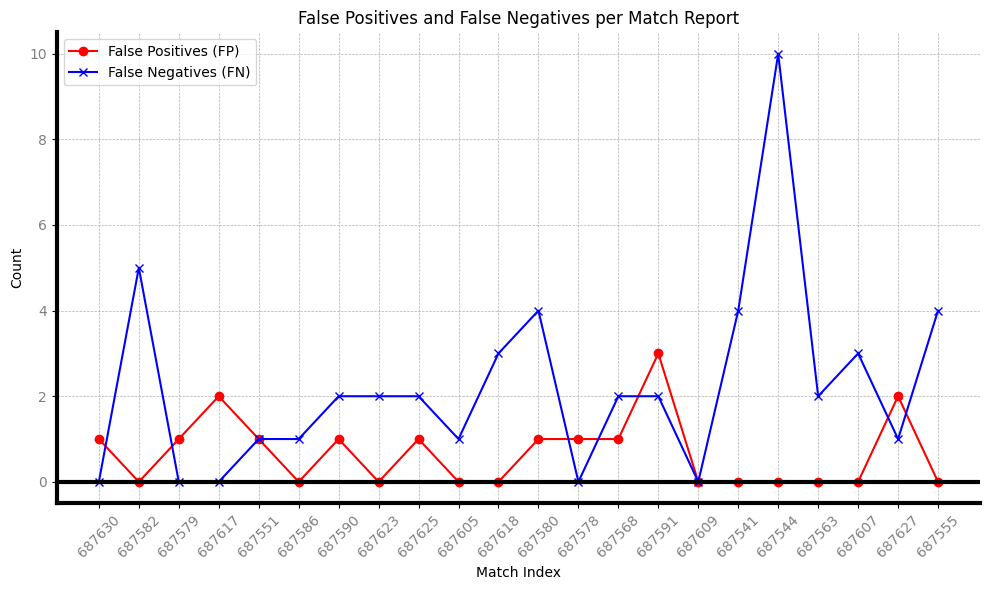

In [29]:
import matplotlib.pyplot as plt

# Select the relevant columns
df = all_results_df[['gameid', 'False Positives (FP)', 'False Negatives (FN)']]

# Drop the 'Average' row if present
df = df[df['gameid'] != 'Average']

# Convert gameid to numeric for plotting
df['gameid'] = pd.to_numeric(df['gameid'])

# Plot the graph
plt.figure(figsize=(10, 6))

# Plotting with the desired style
plt.plot(df.index, df['False Positives (FP)'], label='False Positives (FP)', marker='o', linestyle='-', color='red')
plt.plot(df.index, df['False Negatives (FN)'], label='False Negatives (FN)', marker='x', linestyle='-', color='blue')

# Add a thick line at y = 0
plt.axhline(0, color='black', linewidth=3)

# Add labels and title
plt.xlabel('Match Index')
plt.ylabel('Count')
plt.title('False Positives and False Negatives per Match Report')
plt.legend()

# Customize ticks and grid
plt.xticks(ticks=df.index, labels=df['gameid'], rotation=45, fontsize=10, color='gray')
plt.yticks(fontsize=10, color='gray')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(3)
plt.gca().spines['bottom'].set_linewidth(3)

plt.tight_layout()
plt.show()

In [68]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,1.000000,0.000000,0.947368,0.900000,1.000000
1,687582,4,0.000000,5.000000,0.615385,1.000000,0.444444
2,687579,6,1.000000,0.000000,0.923077,0.857143,1.000000
3,687617,4,2.000000,0.000000,0.800000,0.666667,1.000000
4,687551,10,1.000000,1.000000,0.909091,0.909091,0.909091
5,687586,6,0.000000,1.000000,0.923077,1.000000,0.857143
6,687590,4,1.000000,2.000000,0.727273,0.800000,0.666667
7,687623,3,0.000000,2.000000,0.750000,1.000000,0.600000
8,687625,6,1.000000,2.000000,0.800000,0.857143,0.750000
9,687605,6,0.000000,1.000000,0.923077,1.000000,0.857143


In [64]:
all_results_df

,gameid,True Positives (TP),False Positives (FP),False Negatives (FN),F1 Score,Precision,Recall
0,687630,9,2.000000,0.000000,0.900000,0.818182,1.000000
1,687582,4,0.000000,5.000000,0.615385,1.000000,0.444444
2,687579,6,1.000000,0.000000,0.923077,0.857143,1.000000
3,687617,4,3.000000,0.000000,0.727273,0.571429,1.000000
4,687551,10,4.000000,1.000000,0.800000,0.714286,0.909091
5,687586,6,0.000000,1.000000,0.923077,1.000000,0.857143
6,687590,4,1.000000,2.000000,0.727273,0.800000,0.666667
7,687623,3,0.000000,2.000000,0.750000,1.000000,0.600000
8,687625,6,1.000000,2.000000,0.800000,0.857143,0.750000
9,687605,6,1.000000,1.000000,0.857143,0.857143,0.857143
